In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# (x_train, y_train) = (x_train[:100], y_train[:100])
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

### model

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,LeakyReLU,\
                                    Flatten,Dense,Reshape,Conv2DTranspose

from tensorflow.keras.optimizers import Adam


1. Downsample Using Strided Convolutions (e.g. don’t use pooling layers).
2. Upsample Using Strided Convolutions (e.g. use the transpose convolutional layer).
3. Use LeakyReLU (e.g. don’t use the standard ReLU).
4. Use Batch Normalization (e.g. standardize layer outputs after the activation).
5. Use Gaussian Weight Initialization (e.g. a mean of 0.0 and stdev of 0.02).
6. Use Adam Stochastic Gradient Descent (e.g. learning rate of 0.0002 and beta1 of 0.5).
7. Scale Images to the Range [-1,1] (e.g. use tanh in the output of the generator).

In [4]:
# define the discriminator model
discriminator = Sequential()
# downsample to 14x14
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(alpha=0.2))
# downsample to 7x7
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(alpha=0.2))
# classify
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [5]:
# define the generator model
generator = Sequential()
# foundation for 7x7 image
n_nodes = 64 * 7 * 7
generator.add(Dense(n_nodes, input_dim=100))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7, 7, 64)))
# upsample to 14x14
generator.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
generator.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)       

In [22]:
# make weights in the discriminator not trainable
discriminator.trainable = False
# connect them
gan_model = Sequential()
# add generator
gan_model.add(generator)
# add the discriminator
gan_model.add(discriminator)
# compile gan_model
gan_model.compile(loss='binary_crossentropy', optimizer='adam')

gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         404225    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 41217     
Total params: 445,442
Trainable params: 397,697
Non-trainable params: 47,745
_________________________________________________________________


In [23]:
def select_real_samples(dataset, n_batch):
    number_of_rows = dataset.shape[0]
    random_indices = np.random.choice(number_of_rows, size=n_batch, replace=False)
    random_rows = dataset[random_indices, :]
    random_rows = np.expand_dims(random_rows,axis=3)
    return random_rows, np.ones(n_batch)

select_real_samples(x_train, n_batch)[0].shape,select_real_samples(x_train, n_batch)[1].shape

((2, 28, 28, 1), (2,))

In [24]:
def generate_latent_points(latent_dim, n_batch):
    # generate points in the latent space
	x_input = np.random.randn(latent_dim * n_batch)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_batch, latent_dim)
	return x_input

generate_latent_points(latent_dim, n_batch).shape

(2, 100)

In [157]:
def generate_fake_samples(generator, latent_dim, n_batch):
    x_input = generate_latent_points(latent_dim, n_batch)
    x_fake = generator.predict(x_input)
    y_fake = np.zeros(n_batch)
    return x_fake, y_fake

generate_fake_samples(generator, latent_dim, n_batch)[0].shape,generate_fake_samples(generator, latent_dim, n_batch)[1].shape

x_fake, y_fake = generate_fake_samples(generator, latent_dim, 1)
x_fake

array([[[[ 0.9999999 ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 0.9999999 ],
         [ 1.        ],
         [-0.9999999 ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [-1.        ],
         [ 0.99997395],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [-0.9999636 ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ]],

        [[-0.9999994 ],
         [-0.99999833],
         [-0.99999624],
         [ 1.        ],
         [ 1.        ],
         [-0.9999998 ],
         [ 1.        ],
         [ 1.        ],
         [ 0.9999998 ],
         [ 1.        ],
         [-1.        ],
         [-1.        ],
         [ 1.        ],
         [ 1. 

In [114]:
# gan training algorithm
def train(generator,discriminator,gan_model,n_batch=16,latent_dim=100,n_epochs=10):
    latent_dim = 100
    for i in range(n_epochs):
        # get randomly selected 'real' samples
        X_real, y_real = select_real_samples(x_train, n_batch)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_batch)
        # create training set for the discriminator
        X, y = np.vstack((X_real, X_fake)), np.hstack((y_real, y_fake))
        # update discriminator model weights
        d_loss = discriminator.train_on_batch(X, y)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        if i % 10 == 0:
            print("Epoch", i)
        
train(generator,discriminator,gan_model,n_epochs=10000)

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290
Epoch 300
Epoch 310
Epoch 320
Epoch 330
Epoch 340
Epoch 350
Epoch 360
Epoch 370
Epoch 380
Epoch 390
Epoch 400
Epoch 410
Epoch 420
Epoch 430
Epoch 440
Epoch 450
Epoch 460
Epoch 470
Epoch 480
Epoch 490
Epoch 500
Epoch 510
Epoch 520
Epoch 530
Epoch 540
Epoch 550
Epoch 560
Epoch 570
Epoch 580
Epoch 590
Epoch 600
Epoch 610
Epoch 620
Epoch 630
Epoch 640
Epoch 650
Epoch 660
Epoch 670
Epoch 680
Epoch 690
Epoch 700
Epoch 710
Epoch 720
Epoch 730
Epoch 740
Epoch 750
Epoch 760
Epoch 770
Epoch 780
Epoch 790
Epoch 800
Epoch 810
Epoch 820
Epoch 830
Epoch 840
Epoch 850
Epoch 860
Epoch 870
Epoch 880
Epoch 890
Epoch 900
Epoch 910
Epoch 920
Epoch 930
Epoch 940
Epoch 950
Epoch 960
Epoch 970
Epoch 980
Epoch 990
Epoch 1000


Epoch 7550
Epoch 7560
Epoch 7570
Epoch 7580
Epoch 7590
Epoch 7600
Epoch 7610
Epoch 7620
Epoch 7630
Epoch 7640
Epoch 7650
Epoch 7660
Epoch 7670
Epoch 7680
Epoch 7690
Epoch 7700
Epoch 7710
Epoch 7720
Epoch 7730
Epoch 7740
Epoch 7750
Epoch 7760
Epoch 7770
Epoch 7780
Epoch 7790
Epoch 7800
Epoch 7810
Epoch 7820
Epoch 7830
Epoch 7840
Epoch 7850
Epoch 7860
Epoch 7870
Epoch 7880
Epoch 7890
Epoch 7900
Epoch 7910
Epoch 7920
Epoch 7930
Epoch 7940
Epoch 7950
Epoch 7960
Epoch 7970
Epoch 7980
Epoch 7990
Epoch 8000
Epoch 8010
Epoch 8020
Epoch 8030
Epoch 8040
Epoch 8050
Epoch 8060
Epoch 8070
Epoch 8080
Epoch 8090
Epoch 8100
Epoch 8110
Epoch 8120
Epoch 8130
Epoch 8140
Epoch 8150
Epoch 8160
Epoch 8170
Epoch 8180
Epoch 8190
Epoch 8200
Epoch 8210
Epoch 8220
Epoch 8230
Epoch 8240
Epoch 8250
Epoch 8260
Epoch 8270
Epoch 8280
Epoch 8290
Epoch 8300
Epoch 8310
Epoch 8320
Epoch 8330
Epoch 8340
Epoch 8350
Epoch 8360
Epoch 8370
Epoch 8380
Epoch 8390
Epoch 8400
Epoch 8410
Epoch 8420
Epoch 8430
Epoch 8440
Epoch 8450

In [140]:
def testWeightFreeze(discriminator,generator,gan_model):
    # discriminator changes
    disc_weight_before = discriminator.non_trainable_weights[0][0][0][0][0].numpy()
    gen_weight_before = generator.trainable_weights[0][0][0].numpy()
    train(generator,discriminator,gan_model)
    disc_weight_after = discriminator.non_trainable_weights[0][0][0][0][0].numpy()
    gen_weight_after = generator.trainable_weights[0][0][0].numpy()

    (disc_weight_before, disc_weight_after), (gen_weight_before,gen_weight_after)

### Predictions

In [89]:
import matplotlib.pyplot as plt

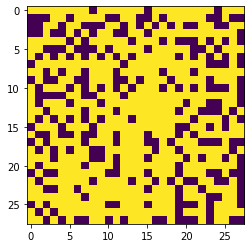

In [150]:
# prepare fake examples
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 1)
generated_sample = x_fake[0].squeeze()
plt.imshow(generated_sample)

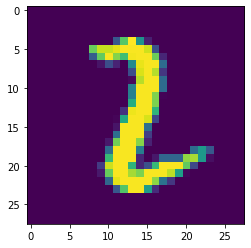

In [110]:
# prepare fake examples
x_real, y_real = select_real_samples(x_train, 1)
real_sample = x_real[0].squeeze()
plt.imshow(real_sample)